Verifica della frequenza di campionamento (per costruire spettrogrammi)

In [ ]:
import torchaudio

# Percorso del file audio
audio_path = "/content/Alessandro_Full.wav"

# Caricamento del file audio
waveform, sample_rate = torchaudio.load(audio_path)

# Visualizzazione della frequenza di campionamento
print(f"La frequenza di campionamento del file è: {sample_rate} Hz")


Spettrogramma del file audio intero

In [ ]:
import torchaudio
import torchaudio.transforms as transforms
import matplotlib.pyplot as plt
import librosa.display

# Parametri per 96,000 Hz
#sample_rate = 96000      # Frequenza di campionamento alta
#n_fft = 4096             # Dimensione della finestra di Fourier
#hop_length = 1024        # Salto tra le finestre
#n_mels = 128             # Numero di bin Mel (opzionale, per mel-spectrogram)

# Parametri per 24,000 Hz
sample_rate = 24000      # Frequenza di campionamento
n_fft = 1024             # Dimensione della finestra di Fourier
hop_length = 256         # Salto tra le finestre
n_mels = 128             # Numero di bin Mel

# Caricamento del file audio ad alta frequenza di campionamento
audio_path = "/content/Alessandro_Full.wav"
waveform, sr = torchaudio.load(audio_path)

# Controllo che il sample rate sia corretto
assert sr == sample_rate, f"La frequenza di campionamento del file ({sr} Hz) non è quella attesa ({sample_rate} Hz)"

# Trasformazione in spettrogramma
spectrogram_transform = transforms.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    n_mels=n_mels
)
spectrogram = spectrogram_transform(waveform)

# Converti a decibel per un'immagine visivamente più comprensibile
spectrogram_db = transforms.AmplitudeToDB()(spectrogram)

# Visualizzazione dello spettrogramma
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db[0].numpy(), sr=sample_rate, hop_length=hop_length, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel-Spectrogram (96,000 Hz)")
plt.show()


Resampling a 24kHz

In [ ]:
import librosa
import soundfile as sf

# Carica l'audio originale
file_path = "/content/Lavinia_Full.wav"
original_audio, original_sr = librosa.load(file_path, sr=96000)  # sr=None evita il resampling automatico

# Effettua il resampling
target_sr = 24000
resampled_audio = librosa.resample(original_audio, orig_sr=original_sr, target_sr=target_sr)

# Salva il file audio resampled
output_path = "resampled_audio.wav"
sf.write(output_path, resampled_audio, target_sr)

print(f"Resampling completato: salvato in {output_path}")


Divisione audio in spettrogrammi (5 o 2 secondi)

In [ ]:
import torch
import torchaudio
import torchaudio.transforms as transforms
import os
import numpy as np
import math
import matplotlib.pyplot as plt

# Parametri
#sample_rate = 96000
#segment_duration = 5
#n_fft = 4096
#hop_length = 1024
#n_mels = 128

sample_rate = 24000
segment_duration = 2      # Frequenza di campionamento
n_fft = 1024             # Dimensione della finestra di Fourier
hop_length = 256         # Salto tra le finestre
n_mels = 128             # Numero di bin Mel

# Creazione cartella per i file PNG degli spettrogrammi
output_folder = 'spectrogram_images'
os.makedirs(output_folder, exist_ok=True)

def audio_to_segments_and_save_spectrograms(audio_path, segment_duration, sample_rate, output_folder):
    waveform, sr = torchaudio.load(audio_path)
    assert sr == sample_rate, f"La frequenza di campionamento del file ({sr} Hz) non è quella attesa ({sample_rate} Hz)"

    segment_samples = segment_duration * sample_rate
    total_samples = waveform.size(1)
    num_segments = math.ceil(total_samples / segment_samples)

    # Trasformazione a MelSpectrogram
    spectrogram_transform = transforms.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )

    for i in range(num_segments):
        start = i * segment_samples
        end = min(start + segment_samples, total_samples)
        segment_waveform = waveform[:, start:end]

        if segment_waveform.size(1) < segment_samples:
            padding = segment_samples - segment_waveform.size(1)
            segment_waveform = torch.nn.functional.pad(segment_waveform, (0, padding))

        spectrogram = spectrogram_transform(segment_waveform)
        spectrogram_db = transforms.AmplitudeToDB()(spectrogram)

        # Normalizzazione del valore dello spettrogramma per una scala visibile
        spectrogram_array = spectrogram_db[0].numpy()
        spectrogram_array -= spectrogram_array.min()  # Porta i valori a partire da 0
        spectrogram_array /= spectrogram_array.max()  # Normalizza in [0, 1]

        # Usa matplotlib per applicare una colormap e salva l'immagine con colori
        plt.figure(figsize=(10, 4))
        plt.imshow(spectrogram_array, cmap='viridis', aspect='auto', origin='lower')  # Usa la colormap viridis
        plt.axis('off')  # Nasconde gli assi per un'immagine pulita

        # Salva il file come immagine PNG colorata
        output_path = os.path.join(output_folder, f"spectrogram_segment_{i+1}.png")
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
        plt.close()

    print(f"Salvati {num_segments} spettrogrammi colorati in '{output_folder}'.")


In [ ]:
# Esempio di utilizzo
audio_path = "/content/resampled_audio.wav"
audio_to_segments_and_save_spectrograms(audio_path, segment_duration, sample_rate, output_folder)


In [ ]:
# Comprimi la cartella in un file zip
!zip -r spectrogram_images.zip spectrogram_images


Spettrogrammi con patch a 1/2 dell'immagine

In [ ]:
import os
from PIL import Image, ImageDraw
import shutil

# Percorsi delle cartelle
original_folder = 'spectrogram_images'            # Cartella con gli spettrogrammi originali
paired_folder = 'paired_spectrograms'              # Cartella per salvare le coppie di immagini
os.makedirs(paired_folder, exist_ok=True)          # Crea la cartella se non esiste

# Funzione per creare una patch nera sulla parte superiore di un'immagine
def apply_patch(image, patch_height_ratio=0.5):
    width, height = image.size
    patch_height = int(height * patch_height_ratio)

    # Creazione di una patch nera
    patched_image = image.copy()
    draw = ImageDraw.Draw(patched_image)
    draw.rectangle([0, 0, width, patch_height], fill="black")

    return patched_image

# Iterazione su tutti i file nella cartella degli spettrogrammi originali
for filename in os.listdir(original_folder):
    if filename.endswith(".png"):
        # Carica l'immagine originale
        original_path = os.path.join(original_folder, filename)
        original_image = Image.open(original_path)

        # Crea l'immagine con la patch
        patched_image = apply_patch(original_image)

        # Salva la coppia di immagini nella cartella delle coppie
        base_filename = os.path.splitext(filename)[0]

        # Salva l'immagine originale
        original_save_path = os.path.join(paired_folder, f"{base_filename}_original.png")
        original_image.save(original_save_path)

        # Salva l'immagine con patch
        patched_save_path = os.path.join(paired_folder, f"{base_filename}_patched.png")
        patched_image.save(patched_save_path)

print(f"Coppie di immagini salvate in '{paired_folder}'.")


In [ ]:
!zip -r paired_spectrograms.zip paired_spectrograms


riorganizzazione cartella

In [ ]:
import os
import shutil
import re

# Cartella contenente i file degli spettrogrammi
source_folder = 'paired_spectrograms'
# Cartella di destinazione organizzata
destination_folder = 'dataset'
os.makedirs(destination_folder, exist_ok=True)

# Ottieni tutti i file PNG nella cartella sorgente
files = [f for f in os.listdir(source_folder) if f.endswith('.png')]

# Usa un dizionario per organizzare i file per segmento
file_dict = {}

for file_name in files:
    # Estrarre l'indice del segmento dal nome del file usando una regex
    match = re.search(r'spectrogram_segment_(\d+)', file_name)
    if match:
        segment_id = int(match.group(1))
        if segment_id not in file_dict:
            file_dict[segment_id] = {}

        # Verifica se è un file originale o patched e aggiungilo al dizionario
        if '_original.png' in file_name:
            file_dict[segment_id]['original'] = file_name
        elif '_patched.png' in file_name:
            file_dict[segment_id]['patched'] = file_name

# Organizza i file in campioni basandosi sul dizionario
for segment_id, file_pair in file_dict.items():
    # Creazione della cartella del campione (es. sample_0, sample_1, ...)
    sample_folder = os.path.join(destination_folder, f"sample_{segment_id}")
    os.makedirs(sample_folder, exist_ok=True)

    # Sposta il file originale se esiste
    if 'original' in file_pair:
        source_original_path = os.path.join(source_folder, file_pair['original'])
        destination_original_path = os.path.join(sample_folder, "original.png")
        shutil.move(source_original_path, destination_original_path)

    # Sposta il file patched se esiste
    if 'patched' in file_pair:
        source_patched_path = os.path.join(source_folder, file_pair['patched'])
        destination_patched_path = os.path.join(sample_folder, "masked.png")
        shutil.move(source_patched_path, destination_patched_path)

print(f"Riorganizzazione completata nella cartella '{destination_folder}'.")


In [ ]:
!zip -r dataset.zip dataset

In [ ]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import zipfile
import os

# Percorso del file zip
zip_path = '/content/paired_spectrograms.zip'
# Cartella di destinazione per i file estratti
extract_folder = 'paired_spectrograms'

# Estrai il contenuto del file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Parametri

In [ ]:
# Parametri
img_size = 128  # Imposta in base alla risoluzione dei tuoi spettrogrammi
batch_size = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset personalizzato per il caricamento delle immagini
class SpectrogramDataset(Dataset):
    def __init__(self, paired_folder, img_size):
        self.paired_folder = paired_folder
        self.img_size = img_size
        self.files = sorted([f for f in os.listdir(paired_folder) if f.endswith("_patched.png")])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        patched_image_path = os.path.join(self.paired_folder, self.files[idx])
        original_image_path = patched_image_path.replace("_patched", "_original")

        # Carica e converte le immagini in tensori normalizzati
        patched_image = Image.open(patched_image_path).convert("L").resize((self.img_size, self.img_size))
        original_image = Image.open(original_image_path).convert("L").resize((self.img_size, self.img_size))

        # Normalizza e converte in tensore
        patched_tensor = torch.tensor(np.array(patched_image) / 255.0, dtype=torch.float32).unsqueeze(0)
        original_tensor = torch.tensor(np.array(original_image) / 255.0, dtype=torch.float32).unsqueeze(0)

        return patched_tensor, original_tensor

# Carica il dataset
dataset = SpectrogramDataset("/content/paired_spectrograms/paired_spectrograms", img_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

U-net

In [ ]:
# Definizione di un semplice U-Net
class SimpleUNet(nn.Module):
    def __init__(self):
        super(SimpleUNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Configura il modello e l'ottimizzatore
model = SimpleUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Funzione per l'addestramento
def train(model, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for patched, original in tqdm(dataloader):
            patched, original = patched.to(device), original.to(device)

            # Previsione e calcolo della loss
            output = model(patched)
            loss = criterion(output, original)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}")

# Avvia l'addestramento
train(model, dataloader, epochs=10)

Improved U-net

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

class ImprovedUNet(nn.Module):
    def __init__(self):
        super(ImprovedUNet, self).__init__()

        # Encoder
        self.encoder1 = self.conv_block(1, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder
        self.decoder3 = self.upconv_block(512, 256)  # Uscita a 256
        self.decoder2 = self.upconv_block(256 + 256, 128)  # 256 + 256 per concatenamento
        self.decoder1 = self.upconv_block(128 + 128, 64)  # 128 + 128 per concatenamento

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU()
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)

        # Bottleneck
        bottleneck = self.bottleneck(enc3)

        # Decoder
        dec3 = self.decoder3(bottleneck)
        dec3 = self.crop_and_concat(dec3, enc3)  # Skip connection
        dec2 = self.decoder2(dec3)
        dec2 = self.crop_and_concat(dec2, enc2)  # Skip connection
        dec1 = self.decoder1(dec2)

        # Ridimensiona l'output finale
        return self.final_conv(dec1)

    def crop_and_concat(self, upsampled, skip):
        # Assicurati che le dimensioni siano compatibili
        if upsampled.size(2) != skip.size(2):
            min_height = min(upsampled.size(2), skip.size(2))
            upsampled = upsampled[:, :, :min_height, :]
            skip = skip[:, :, :min_height, :]

        if upsampled.size(3) != skip.size(3):
            min_width = min(upsampled.size(3), skip.size(3))
            upsampled = upsampled[:, :, :, :min_width]
            skip = skip[:, :, :, :min_width]

        return torch.cat((upsampled, skip), dim=1)

# Configura il modello e l'ottimizzatore
model = ImprovedUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Funzione per l'addestramento
def train(model, dataloader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for patched, original in tqdm(dataloader):
            patched, original = patched.to(device), original.to(device)

            # Previsione e calcolo della loss
            output = model(patched)

            # Ridimensiona l'output se necessario
            if output.size() != original.size():
                output = nn.functional.interpolate(output, size=original.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(output, original)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader)}")

# Avvia l'addestramento
train(model, dataloader, epochs=10)

In [ ]:
def infer_and_show(model, dataloader, num_images=5):
    model.eval()
    patched_images, original_images, inpainted_images = [], [], []
    count = 0

    with torch.no_grad():
        for patched, original in dataloader:
            patched, original = patched.to(device), original.to(device)
            output = model(patched)

            # Estrai singole immagini dai batch
            for i in range(patched.size(0)):
                if count >= num_images:
                    break
                patched_images.append(patched[i].cpu().squeeze().numpy())
                original_images.append(original[i].cpu().squeeze().numpy())
                inpainted_images.append(output[i].cpu().squeeze().numpy())
                count += 1

            if count >= num_images:
                break

    # Visualizza i risultati
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
    for i in range(num_images):
        axs[i, 0].imshow(patched_images[i], cmap="viridis")
        axs[i, 1].imshow(original_images[i], cmap="viridis")
        axs[i, 2].imshow(inpainted_images[i], cmap="viridis")
        axs[i, 0].set_title("Con Patch")
        axs[i, 1].set_title("Originale")
        axs[i, 2].set_title("Ricostruito")
        for ax in axs[i]:
            ax.axis("off")
    plt.show()


In [ ]:
# Prova a visualizzare i risultati
infer_and_show(model, dataloader, num_images=5)

Improved U-net 2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import os

# Definizione della dimensione del batch
batch_size = 8  # Puoi regolare questo valore per ottimizzare l'uso della memoria

# Definizione della classe del dataset con augmentazioni
class SpectrogramDataset(Dataset):
    def __init__(self, paired_folder, img_size):
        self.paired_folder = paired_folder
        self.img_size = img_size
        self.files = sorted([f for f in os.listdir(paired_folder) if f.endswith("_patched.png")])
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),  # Ruota casualmente di 10 gradi
            transforms.ToTensor(),  # Converte in tensore e normalizza
            transforms.Lambda(lambda x: x * 2 - 1)  # Normalizza tra [-1, 1]
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        patched_image_path = os.path.join(self.paired_folder, self.files[idx])
        original_image_path = patched_image_path.replace("_patched", "_original")

        # Carica e applica le trasformazioni
        patched_image = Image.open(patched_image_path).convert("L")
        original_image = Image.open(original_image_path).convert("L")

        patched_image = self.transform(patched_image)
        original_image = self.transform(original_image)

        return patched_image, original_image

# Modello U-Net migliorato
class ImprovedUNet(nn.Module):
    def __init__(self):
        super(ImprovedUNet, self).__init__()

        # Encoder
        self.encoder1 = self.conv_block(1, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)  # Aggiunto livello extra

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)  # Aumentato il numero di filtri

        # Decoder
        self.decoder4 = self.upconv_block(1024, 512)
        self.decoder3 = self.upconv_block(512 + 512, 256)
        self.decoder2 = self.upconv_block(256 + 256, 128)
        self.decoder1 = self.upconv_block(128 + 128, 64)

        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU()
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)  # Livello extra

        # Bottleneck
        bottleneck = self.bottleneck(enc4)

        # Decoder
        dec4 = self.decoder4(bottleneck)
        dec4 = self.crop_and_concat(dec4, enc4)  # Skip connection
        dec3 = self.decoder3(dec4)
        dec3 = self.crop_and_concat(dec3, enc3)  # Skip connection
        dec2 = self.decoder2(dec3)
        dec2 = self.crop_and_concat(dec2, enc2)  # Skip connection
        dec1 = self.decoder1(dec2)

        return self.final_conv(dec1)

    def crop_and_concat(self, upsampled, skip):
        # Assicurati che le dimensioni siano compatibili
        if upsampled.size(2) != skip.size(2):
            min_height = min(upsampled.size(2), skip.size(2))
            upsampled = upsampled[:, :, :min_height, :]
            skip = skip[:, :, :min_height, :]

        if upsampled.size(3) != skip.size(3):
            min_width = min(upsampled.size(3), skip.size(3))
            upsampled = upsampled[:, :, :, :min_width]
            skip = skip[:, :, :, :min_width]

        return torch.cat((upsampled, skip), dim=1)

# Configura il modello e l'ottimizzatore
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ImprovedUNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # Ridotto il learning rate
criterion = nn.MSELoss()

# Funzione per l'addestramento
def train(model, dataloader, epochs=10):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for patched, original in tqdm(dataloader):
            patched, original = patched.to(device), original.to(device)

            # Previsione e calcolo della loss
            output = model(patched)

            # Ridimensiona l'output se necessario
            if output.size() != original.size():
                output = nn.functional.interpolate(output, size=original.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(output, original)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        average_loss = total_loss / len(dataloader)
        losses.append(average_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss}")

        # Liberare la memoria
        torch.cuda.empty_cache()  # Forza la pulizia della memoria GPU

    # Visualizza la loss
    plt.plot(losses)
    plt.title('Loss durante l\'addestramento')
    plt.xlabel('Epoche')
    plt.ylabel('Loss')
    plt.show()

# Carica il dataset
dataset = SpectrogramDataset("/content/paired_spectrograms/paired_spectrograms", img_size=128)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Avvia l'addestramento
train(model, dataloader, epochs=10)

Audio U-Net

In [ ]:
import zipfile
import os

# Percorso del file zip
zip_path = '/content/paired_spectrograms_alessandro_full.zip'
# Cartella di destinazione per i file estratti
extract_folder = 'paired_spectrograms'

# Estrai il contenuto del file zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.transforms import functional as TF

In [2]:
class SpectrogramPairedDataset(Dataset):
    def __init__(self, root_dirs):
        # Controlla se root_dirs è una lista, altrimenti convertila in lista
        if isinstance(root_dirs, str):
            root_dirs = [root_dirs]

        self.samples = []
        for root_dir in root_dirs:
            # Aggiungi i campioni di ogni directory
            self.samples += [
                os.path.join(root_dir, sample) for sample in sorted(os.listdir(root_dir))
                if os.path.isdir(os.path.join(root_dir, sample)) and
                   os.path.exists(os.path.join(root_dir, sample, "masked.png")) and
                   os.path.exists(os.path.join(root_dir, sample, "original.png"))
            ]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_dir = self.samples[idx]
        masked_path = os.path.join(sample_dir, "masked.png")
        original_path = os.path.join(sample_dir, "original.png")

        input_spec = Image.open(masked_path).convert("L")
        target_spec = Image.open(original_path).convert("L")

        # Aggiungi padding per rendere divisibile per 16
        input_spec = TF.pad(input_spec, self.calculate_padding(input_spec.size), fill=0, padding_mode="constant")
        target_spec = TF.pad(target_spec, self.calculate_padding(target_spec.size), fill=0, padding_mode="constant")

        input_spec = torch.tensor(np.array(input_spec), dtype=torch.float32).unsqueeze(0) / 255.0
        target_spec = torch.tensor(np.array(target_spec), dtype=torch.float32).unsqueeze(0) / 255.0

        return input_spec, target_spec

    def calculate_padding(self, size):
        h, w = size
        pad_h = (16 - h % 16) % 16
        pad_w = (16 - w % 16) % 16
        return (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)



In [3]:
class AudioUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(AudioUNet, self).__init__()

        # Encoder
        self.encoder = nn.ModuleList([
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1)
        ])

        self.pool = nn.MaxPool2d(2, ceil_mode=True)

        # Bottleneck (modifica i canali per corrispondere ai livelli di decodifica)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        )

        # Decoder
        self.decoder = nn.ModuleList([
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2),  # Modifica qui per allineare i canali
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        ])

        # Strati di convoluzione nel decoder
        self.decoder_conv = nn.ModuleList([
            nn.Conv2d(1024, 512, kernel_size=3, padding=1),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 64, kernel_size=3, padding=1)
        ])

        # Convoluzione finale
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for layer in self.encoder:
            x = F.relu(layer(x))
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder con skip connections
        skip_connections = skip_connections[::-1]
        for i in range(len(self.decoder)):
            x = self.decoder[i](x)
            skip_connection = skip_connections[i]

            # Padding per far combaciare le dimensioni se necessario
            if x.shape != skip_connection.shape:
                x = F.pad(x, (0, skip_connection.shape[3] - x.shape[3], 0, skip_connection.shape[2] - x.shape[2]))

            # Concatenazione e convoluzione
            x = torch.cat([x, skip_connection], dim=1)
            x = F.relu(self.decoder_conv[i](x))

        # Layer finale
        x = self.final_conv(x)
        return x


# Parametri di addestramento
batch_size = 32
num_epochs = 24
learning_rate = 0.001


root_dirs = [
    "/home/cscpower/Desktop/audiorestoration/spectrograms/spectrograms/dataset_Alessandro",
    "/home/cscpower/Desktop/audiorestoration/spectrograms/spectrograms/dataset_Federica",
    "/home/cscpower/Desktop/audiorestoration/spectrograms/spectrograms/dataset_Giulio",
    "/home/cscpower/Desktop/audiorestoration/spectrograms/spectrograms/dataset_Lavinia"
]

# Dataset e DataLoader
dataset = SpectrogramPairedDataset(root_dirs)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Modello, perdita e ottimizzatore
model = AudioUNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Ciclo di addestramento
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for input_spec, target_spec in data_loader:
        optimizer.zero_grad()
        output = model(input_spec)
        loss = criterion(output, target_spec)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(data_loader):.4f}")



Epoch [1/24], Loss: 0.6408
Epoch [2/24], Loss: 0.0352
Epoch [3/24], Loss: 0.0172
Epoch [4/24], Loss: 0.0115
Epoch [5/24], Loss: 0.0105
Epoch [6/24], Loss: 0.0097
Epoch [7/24], Loss: 0.0094
Epoch [8/24], Loss: 0.0086
Epoch [9/24], Loss: 0.0073
Epoch [10/24], Loss: 0.0065
Epoch [11/24], Loss: 0.0063
Epoch [12/24], Loss: 0.0066
Epoch [13/24], Loss: 0.0048
Epoch [14/24], Loss: 0.0040
Epoch [15/24], Loss: 0.0035
Epoch [16/24], Loss: 0.0031
Epoch [17/24], Loss: 0.0029
Epoch [18/24], Loss: 0.0027
Epoch [19/24], Loss: 0.0026
Epoch [20/24], Loss: 0.0025


KeyboardInterrupt: 

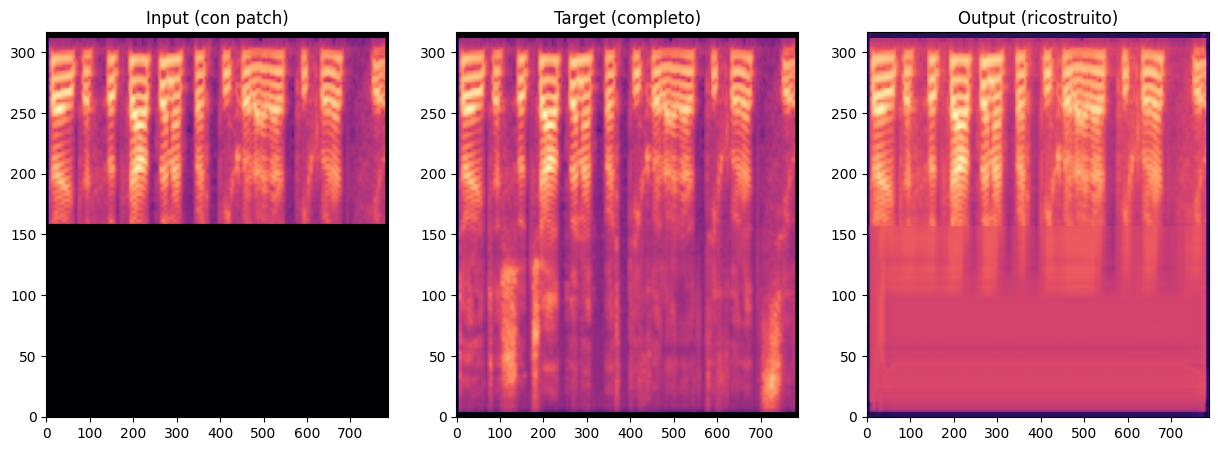

In [4]:

# Visualizzazione dei risultati
def plot_results(input_spec, target_spec, output_spec):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(input_spec.squeeze(), aspect='auto', origin='lower', cmap='magma')
    axs[0].set_title("Input (con patch)")
    axs[1].imshow(target_spec.squeeze(), aspect='auto', origin='lower', cmap='magma')
    axs[1].set_title("Target (completo)")
    axs[2].imshow(output_spec.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='magma')
    axs[2].set_title("Output (ricostruito)")
    plt.show()

# Esempio di visualizzazione
model.eval()
with torch.no_grad():
    for input_spec, target_spec in data_loader:
        output_spec = model(input_spec)
        plot_results(input_spec[0], target_spec[0], output_spec[0])
        break

Audio U-Net Improved

aumentato i canali nei livelli di convoluzione per catturare più dettagli nello spettrogramma.
Leaky ReLU e Tanh: LeakyReLU nelle attivazioni nascoste per evitare che il modello tronchi valori negativi. L'ultimo livello usa tanh per limitare l'output tra -1 e 1.
Funzione di Perdita Combinata (CombinedLoss): funzione di perdita che combina MSE e SSIM, con un peso alpha per bilanciare i due contributi. SSIM aiuta a preservare la struttura globale dello spettrogramma.

In [ ]:
pip install torchmetrics

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.transforms import functional as TF
from torchmetrics.image import StructuralSimilarityIndexMeasure

In [ ]:
# Dataset per caricamento delle immagini
class SpectrogramPairedDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.samples = [
            sample for sample in sorted(os.listdir(root_dir))
            if os.path.isdir(os.path.join(root_dir, sample)) and
               os.path.exists(os.path.join(root_dir, sample, "masked.png")) and
               os.path.exists(os.path.join(root_dir, sample, "original.png"))
        ]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample_dir = os.path.join(self.root_dir, self.samples[idx])
        masked_path = os.path.join(sample_dir, "masked.png")
        original_path = os.path.join(sample_dir, "original.png")

        input_spec = Image.open(masked_path).convert("L")
        target_spec = Image.open(original_path).convert("L")

        # Aggiungi padding per rendere divisibile per 16
        input_spec = TF.pad(input_spec, self.calculate_padding(input_spec.size), fill=0, padding_mode="constant")
        target_spec = TF.pad(target_spec, self.calculate_padding(target_spec.size), fill=0, padding_mode="constant")

        input_spec = torch.tensor(np.array(input_spec), dtype=torch.float32).unsqueeze(0) / 255.0
        target_spec = torch.tensor(np.array(target_spec), dtype=torch.float32).unsqueeze(0) / 255.0

        return input_spec, target_spec

    def calculate_padding(self, size):
        h, w = size
        pad_h = (16 - h % 16) % 16
        pad_w = (16 - w % 16) % 16
        return (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)

# Modello Audio U-Net corretto
class AudioUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(AudioUNet, self).__init__()

        # Encoder
        self.encoder = nn.ModuleList([
            nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        ])

        self.pool = nn.MaxPool2d(2, ceil_mode=True)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(1024, 2048, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1)
        )

        # Decoder
        self.decoder = nn.ModuleList([
            nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        ])

        # Convoluzioni del decoder
        self.decoder_conv = nn.ModuleList([
            nn.Conv2d(1024 + 512, 512, kernel_size=3, padding=1),
            nn.Conv2d(512 + 256, 256, kernel_size=3, padding=1),
            nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1)
        ])

        # Convoluzione finale con tanh
        self.final_conv = nn.Conv2d(128, out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for layer in self.encoder:
            x = F.leaky_relu(layer(x))
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder con skip connections
        skip_connections = skip_connections[::-1]
        for i in range(len(self.decoder)):
            x = self.decoder[i](x)
            skip_connection = skip_connections[i]

            if x.shape != skip_connection.shape:
                x = F.pad(x, (0, skip_connection.shape[3] - x.shape[3], 0, skip_connection.shape[2] - x.shape[2]))

            x = torch.cat([x, skip_connection], dim=1)
            x = F.leaky_relu(self.decoder_conv[i](x))

        # Layer finale con tanh
        x = torch.tanh(self.final_conv(x))
        return x

# Perdita combinata (MSE + SSIM)
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.7):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0)

    def forward(self, output, target):
        # Ridimensiona l'output alle dimensioni del target
        output = F.interpolate(output, size=target.shape[2:], mode="bilinear", align_corners=False)

        mse_loss = self.mse(output, target)
        ssim_loss = 1 - self.ssim(output, target)  # 1 - SSIM per usarlo come perdita
        return self.alpha * mse_loss + (1 - self.alpha) * ssim_loss

# Parametri di addestramento
batch_size = 32
num_epochs = 20
learning_rate = 0.0001

In [ ]:
# Data loader
dataset = SpectrogramPairedDataset("/content/paired_spectrograms/paired_spectrograms_alessandro_full")
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Inizializzazione del modello, funzione di perdita e ottimizzatore
model = AudioUNet()
criterion = CombinedLoss(alpha=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Ciclo di addestramento
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for input_spec, target_spec in data_loader:
        optimizer.zero_grad()
        output = model(input_spec)
        loss = criterion(output, target_spec)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Stampa la perdita media per epoca
    avg_loss = total_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")



In [ ]:
# Visualizzazione dei risultati
def plot_results(input_spec, target_spec, output_spec):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(input_spec.squeeze(), aspect='auto', origin='lower', cmap='magma')
    axs[0].set_title("Input (con patch)")
    axs[1].imshow(target_spec.squeeze(), aspect='auto', origin='lower', cmap='magma')
    axs[1].set_title("Target (completo)")
    axs[2].imshow(output_spec.squeeze().detach().numpy(), aspect='auto', origin='lower', cmap='magma')
    axs[2].set_title("Output (ricostruito)")
    plt.show()

# Esempio di visualizzazione dei risultati
model.eval()
with torch.no_grad():
    for input_spec, target_spec in data_loader:
        output_spec = model(input_spec)
        output_spec_resized = F.interpolate(output_spec, size=target_spec.shape[2:], mode="bilinear", align_corners=False)
        plot_results(input_spec[0], target_spec[0], output_spec_resized[0])
        break